## $\Lambda$ Identification using deep learing for p(4.5GeV)+p in HADES

Some important import statements

In [2]:
import torch
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.cm as cm
import sklearn.metrics as metrics
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print ('Training on GPU')
else: print ('Training on CPU')

Training on GPU


In [4]:
def load_events():
    signal = pd.read_csv('Signal_ascii.csv')
    backgd = pd.read_csv('Background_ascii.csv')
    
    signal['typ'] = np.ones(signal.shape[0])
    backgd['typ'] = np.zeros(backgd.shape[0])
    
    signal_train, signal_test = train_test_split(signal, test_size=0.2)
    backgd_train, backgd_test = train_test_split(backgd, test_size=0.2)
    
    return pd.concat([signal_train, backgd_train], ignore_index=True), \
           pd.concat([signal_test, backgd_test], ignore_index=True)

### Label 1 are signal events $p(4.5GeV) \rightarrow pK^{+}\Lambda$  
### Label 0 are background events $p(4.5GeV) \rightarrow pp\pi^{+}\pi^{-}$

In [14]:
%%time
train, test = load_events()
print (train.head(5))
print ()
print ('\nTotal number of training signal events: ', train.loc[train.typ==1].shape[0])
print ('Total number of training background events: ', train.loc[train.typ==0].shape[0])
print ()

        ppx       ppy      ppz       pe      pipx      pipy      pipz  \
0 -0.544565 -0.652874  2.77483  3.05006 -0.027683 -0.189384  0.392879   
1 -0.402791 -0.201938  1.12779  1.53469 -0.111038 -0.123836  0.382403   
2 -0.124278  0.641716  1.00579  1.52290  0.051811  0.228285  0.240357   
3  0.501833 -0.151114  1.16604  1.58577  0.223257 -0.030332  0.223109   
4  0.462985  0.540783  1.52223  1.92466  0.192755  0.100134  0.211295   

        pie     d_ppi     d_p_pvtx    d_pi_pvtx  d_svtx_pvtx       pva  \
0  0.458767  2.135470      5.21035      7.96129      45.0554  0.077053   
1  0.439748  0.523784  16755.30000  16937.60000   17315.4000  1.327020   
2  0.363389  0.554881  11780.20000   7707.62000   17300.9000  0.684387   
3  0.346443  5.359920      1.06803     12.20870      28.2968  0.129233   
4  0.333629  4.598170   8617.38000   4815.70000   17357.9000  0.468303   

           d_l     alpha       q_t        oa       ml  typ  
0      3.46822  0.743502  0.094278  0.249930  1.11382  

#### Plot the variables used in the training

<IPython.core.display.Javascript object>


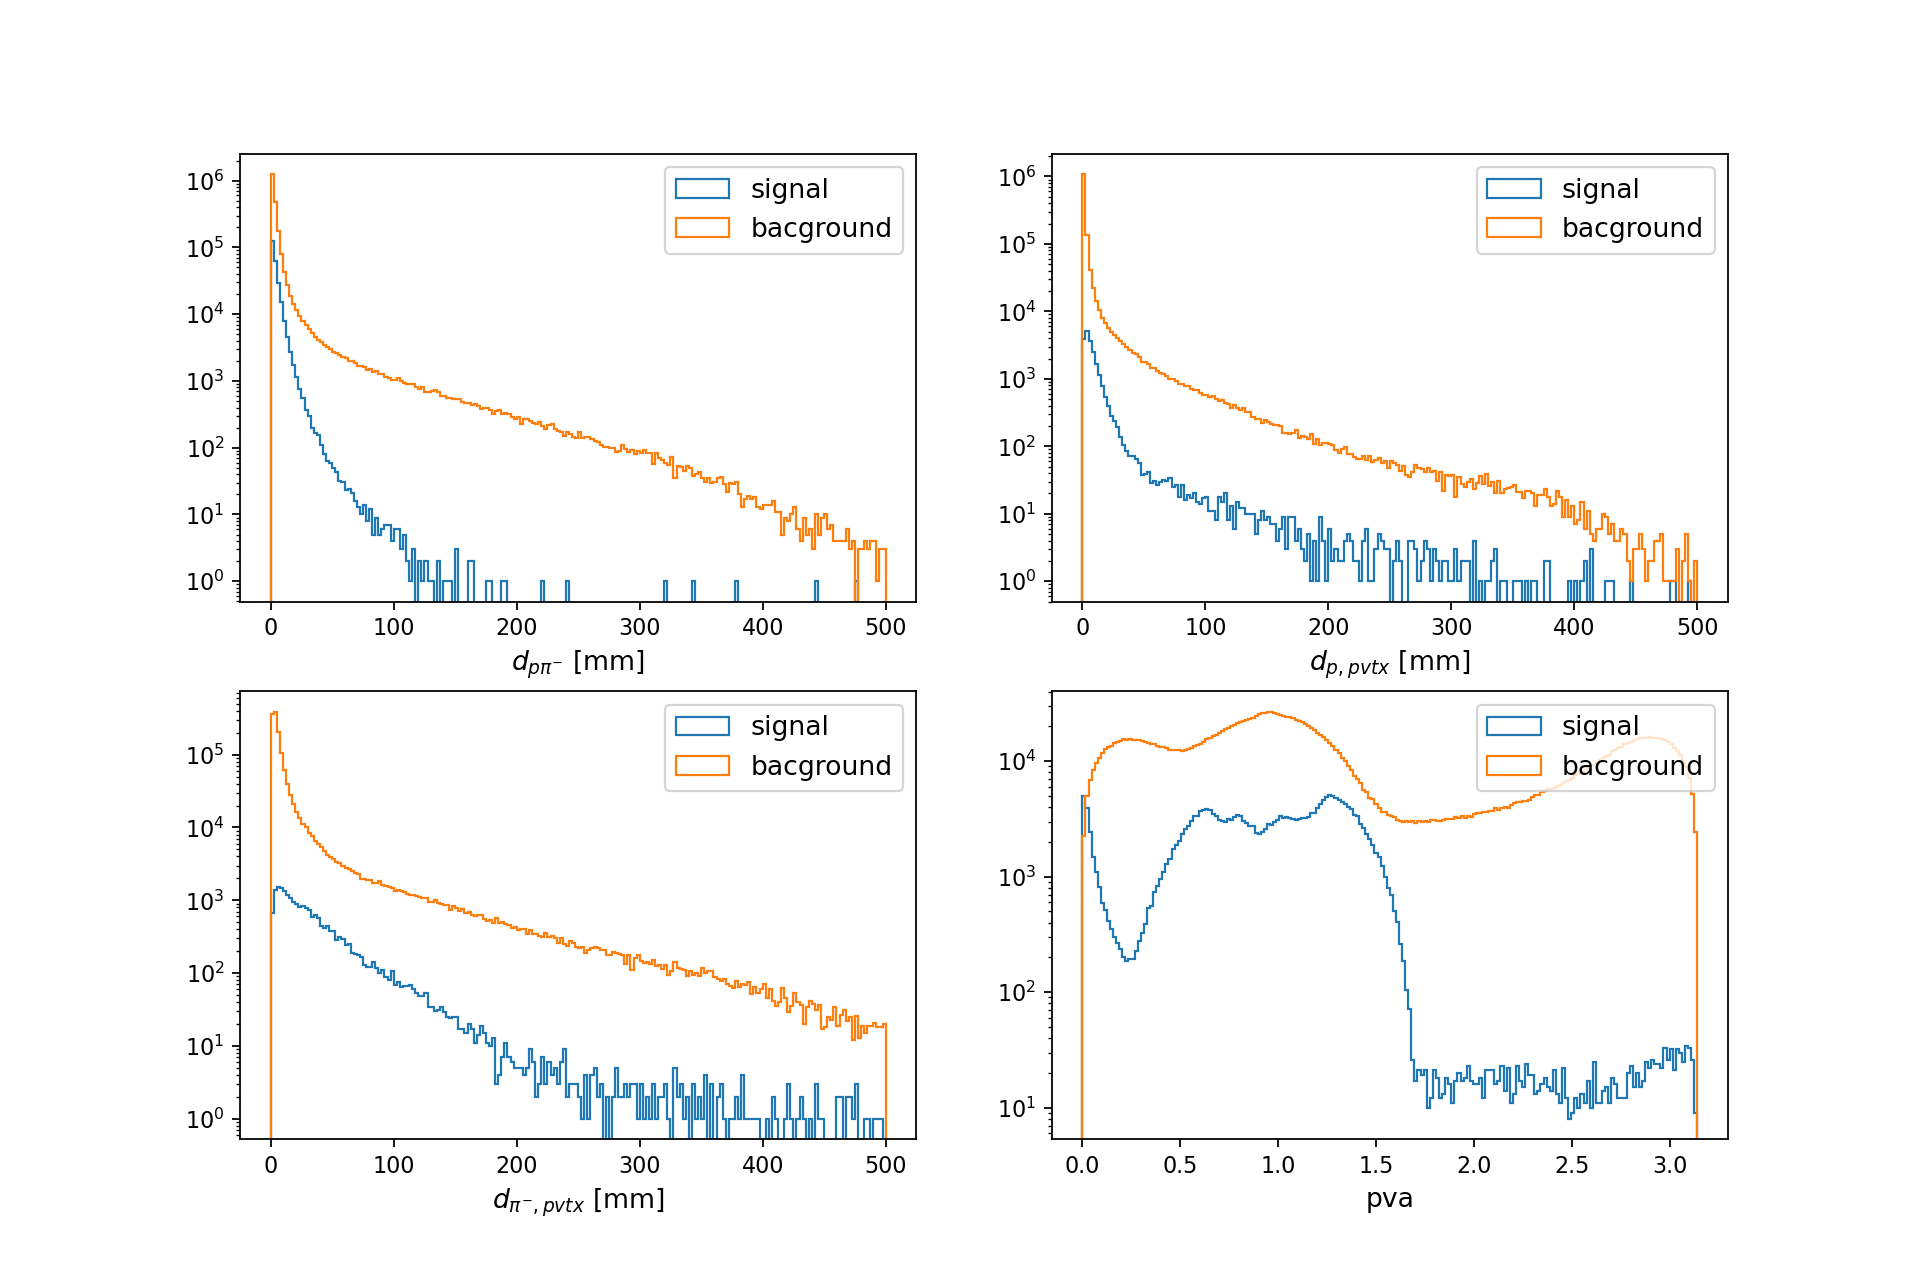

In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

df = train

plt.subplot(2, 2, 1)
plt.hist(df.loc[df.typ==1].d_ppi, histtype='step', bins=200, label='signal', range=(0,500))
plt.hist(df.loc[df.typ==0].d_ppi, histtype='step', bins=200, label='bacground', range=(0,500))
plt.xlabel(r'$d_{p\pi^{-}}$ [mm]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)


plt.subplot(2, 2, 2)
plt.hist(df.loc[df.typ==1].d_p_pvtx, histtype='step', bins=200, label='signal', range=(0,500))
plt.hist(df.loc[df.typ==0].d_p_pvtx, histtype='step', bins=200, label='bacground', range=(0,500))
plt.xlabel(r'$d_{p, pvtx}$ [mm]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

plt.subplot(2, 2, 3)
plt.hist(df.loc[df.typ==1].d_pi_pvtx, histtype='step', bins=200, label='signal', range=(0,500))
plt.hist(df.loc[df.typ==0].d_pi_pvtx, histtype='step', bins=200, label='bacground', range=(0,500))
plt.xlabel(r'$d_{\pi^{-}, pvtx}$ [mm]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

plt.subplot(2, 2, 4)
plt.hist(df.loc[df.typ==1].pva, histtype='step', bins=200, label='signal', range=(0,3.14))
plt.hist(df.loc[df.typ==0].pva, histtype='step', bins=200, label='bacground', range=(0,3.14))
plt.xlabel(r'pva', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)


plt.show()

<IPython.core.display.Javascript object>


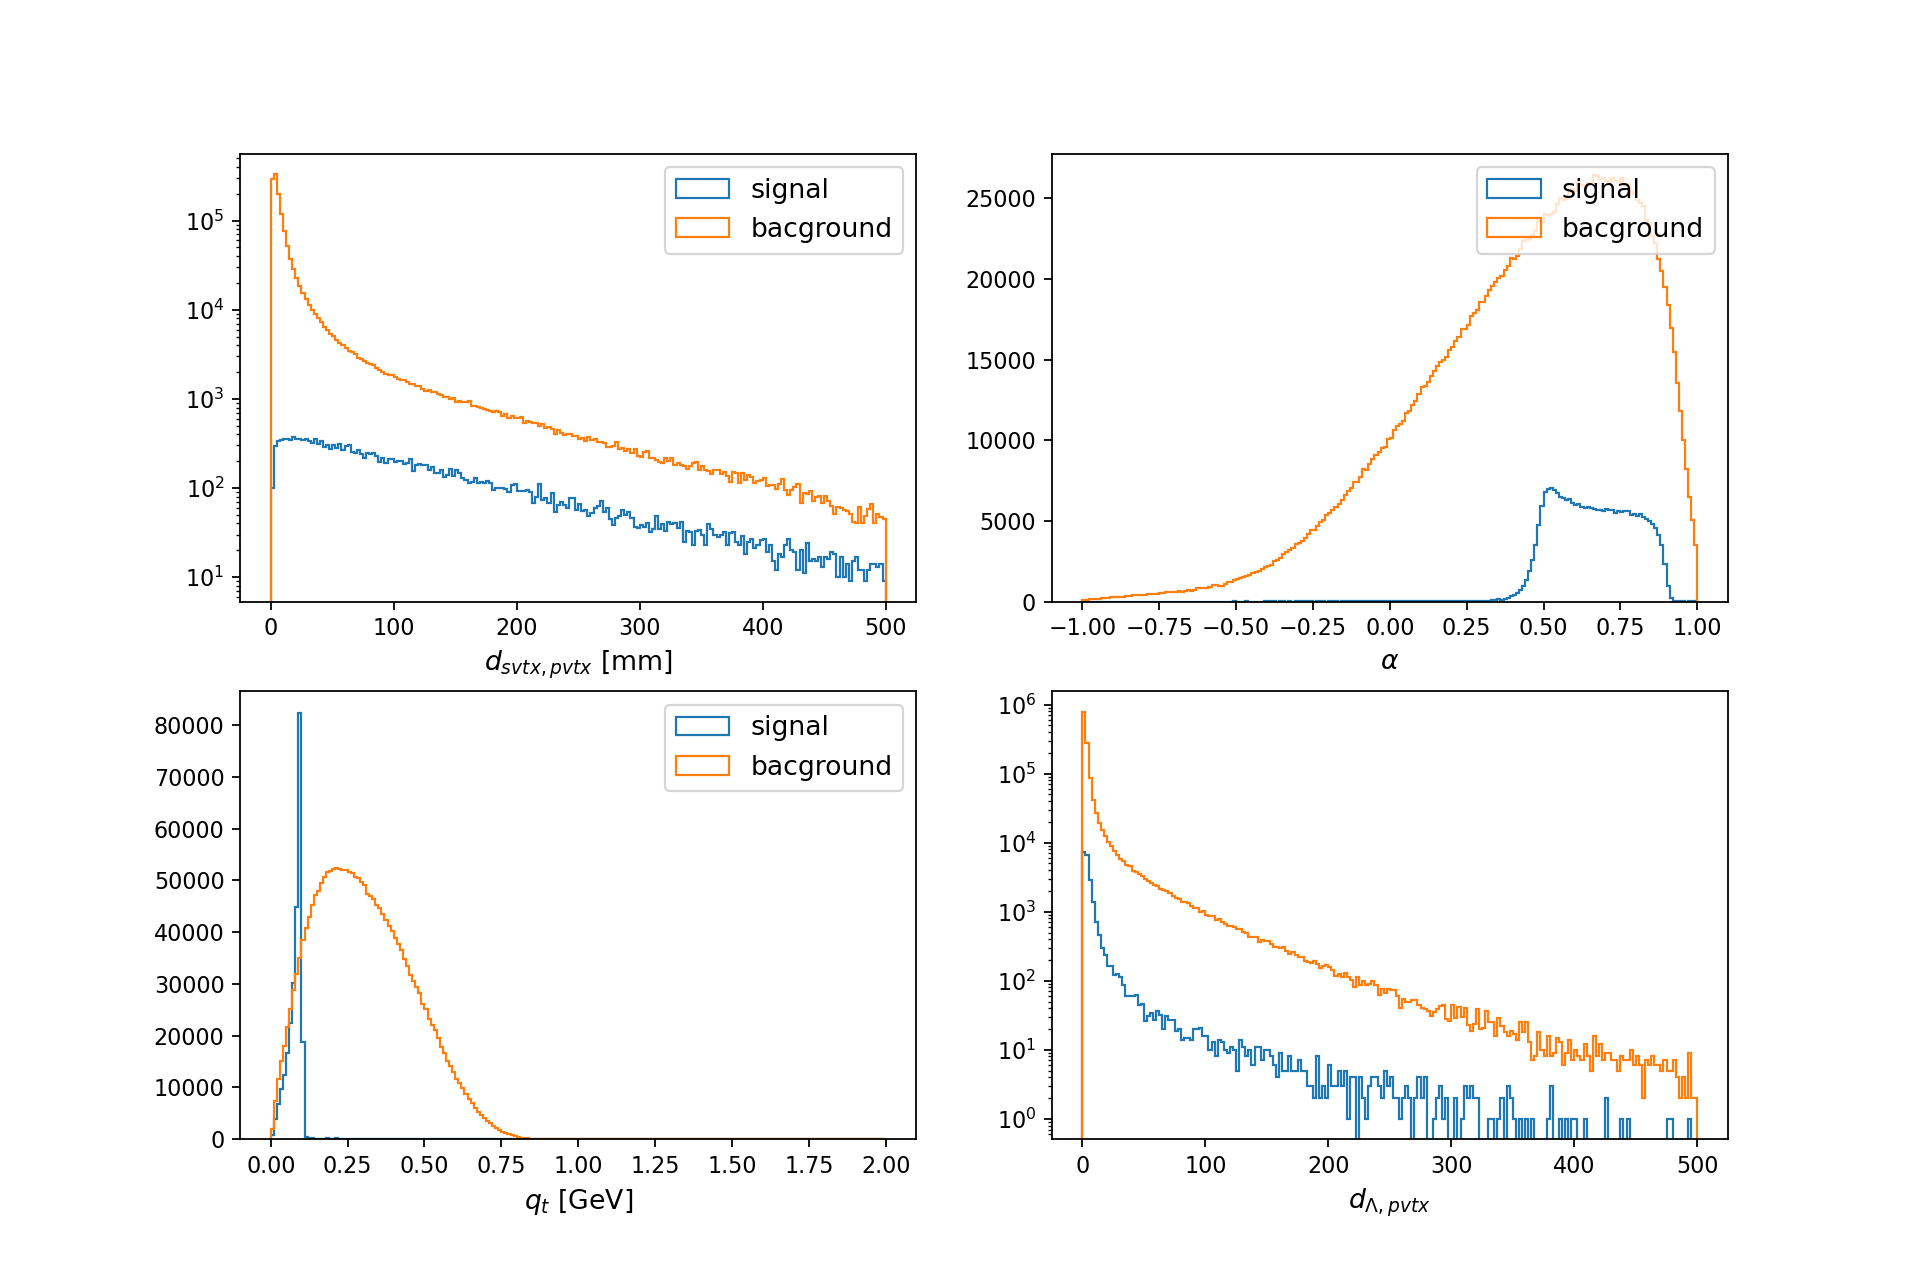

In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

plt.subplot(2, 2, 1)
plt.hist(df.loc[df.typ==1].d_svtx_pvtx, histtype='step', bins=200, label='signal', range=(0,500))
plt.hist(df.loc[df.typ==0].d_svtx_pvtx, histtype='step', bins=200, label='bacground', range=(0,500))
plt.xlabel(r'$d_{svtx, pvtx}$ [mm]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

plt.subplot(2, 2, 4)
plt.hist(df.loc[df.typ==1].d_l, histtype='step', bins=200, label='signal', range=(0,500))
plt.hist(df.loc[df.typ==0].d_l, histtype='step', bins=200, label='bacground', range=(0,500))
plt.semilogy()
plt.xlabel(r'$d_{\Lambda, pvtx}$', fontsize=12)


plt.subplot(2, 2, 2)
plt.hist(df.loc[df.typ==1].alpha, histtype='step', bins=200, label='signal', range=(-1,1))
plt.hist(df.loc[df.typ==0].alpha, histtype='step', bins=200, label='bacground', range=(-1,1))
plt.xlabel(r'$\alpha$', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(2, 2, 3)
plt.hist(df.loc[df.typ==1].q_t, histtype='step', bins=200, label='signal', range=(0,2))
plt.hist(df.loc[df.typ==0].q_t, histtype='step', bins=200, label='bacground', range=(0,2))
plt.xlabel(r'$q_{t}$ [GeV]', fontsize=12)
plt.legend(fontsize=12)



plt.show()

#### The Armenteros Plot for the $\Lambda$ candidates
This is a two dimensional plot, of transverse momentum $p_{T}$ of the oppositely charged decay products with respect to the $V_{0}$ versus the longitudinal momentum asymmetry $\alpha$

<IPython.core.display.Javascript object>


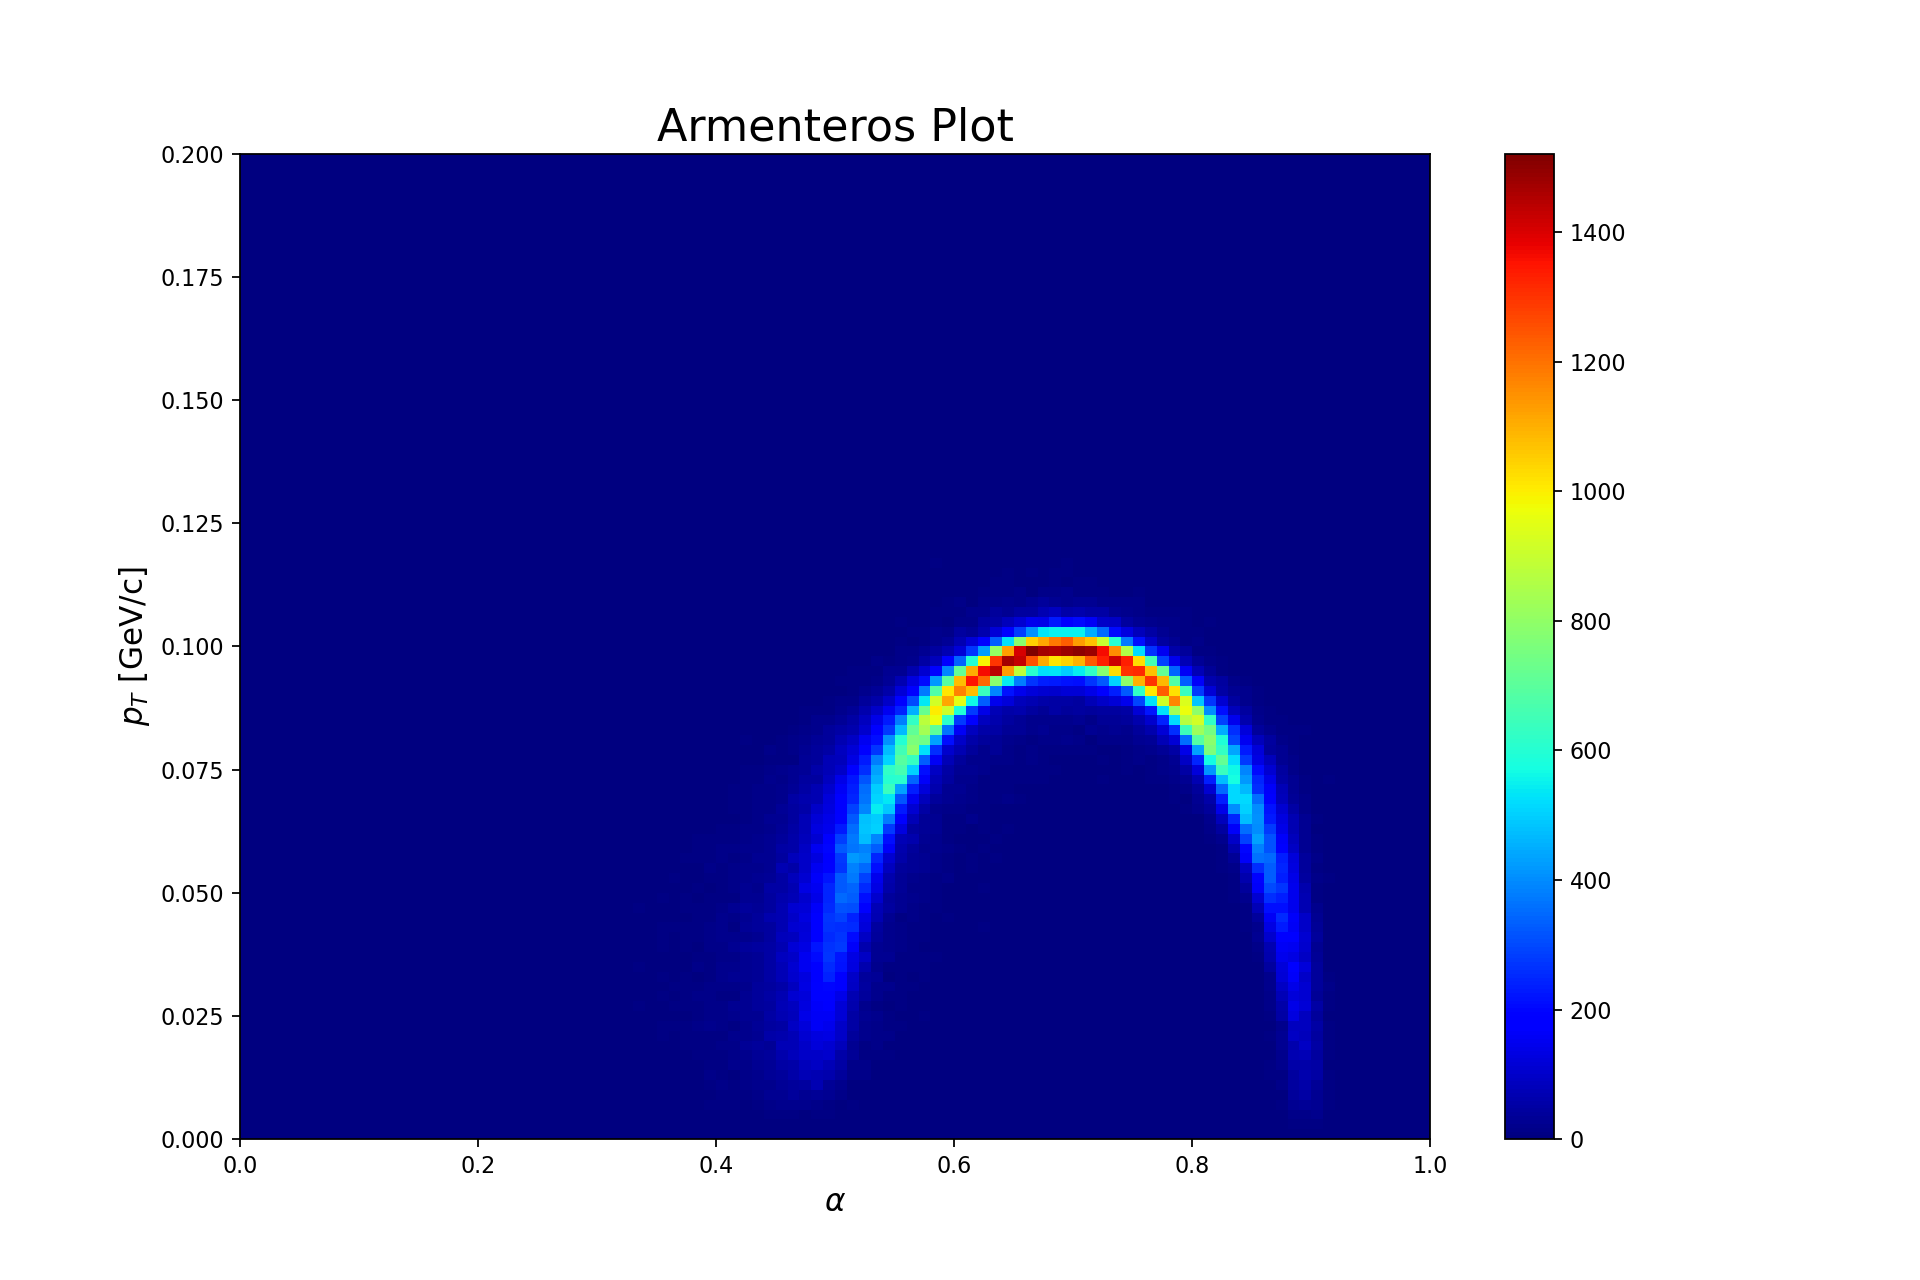

In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)
_ = plt.hist2d(df.loc[df.typ==1].alpha, df.loc[df.typ==1].q_t, bins=(100, 100), range=[[0, 1], [0, 0.2]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title('Armenteros Plot', fontsize=20)
plt.colorbar()

#### Create the training dataset class

In [6]:
class LambdaDataset(Dataset):
    '''Create Training Dataset'''

    def __init__(self, data=None):     
        self.__df          = data
        self.__X, self.__y = self.__items()
    
    def __items(self, verbose=False):
        # select features for training
        df = self.__df[['d_ppi','d_p_pvtx','d_pi_pvtx','pva','d_svtx_pvtx', 'alpha','q_t','typ']]
        
        scale = np.array([100., 100., 100., 1., 100., 1., 1.])
        
        # randomly split the training set
        X_train, _ , y_train, _ = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1], \
                                                   test_size=0.05, random_state=42)
        
        X_train = X_train.to_numpy()/scale
        
        # now scale your data using the StandardScaler
        #scaler  = StandardScaler()
        #X_train = scaler.fit_transform(X_train)
        y_train = y_train.to_numpy()
        
        return X_train, y_train
    
    def __len__(self):
        return len(self.__X)
    
    def getX(self):
        return self.__X
    
    def gety(self):
        return self.__y    
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.__X[idx]), torch.FloatTensor([self.__y[idx]])    

In [7]:
# create the training dataset
train_data = LambdaDataset(data=train)
test_data = LambdaDataset(data=test)

In [10]:
# for balancing the dataset
All = train_data.gety().astype(int)
_df = pd.DataFrame(All, columns=['labels'])
labels_unique, counts = np.unique(_df['labels'], return_counts=True)

class_weights = [sum(counts)/c for c in counts]
weights = [class_weights[e] for e in _df['labels']]
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(_df))

# define the batch_size
batch_size = int(8*1024)
print (len(train_data)/batch_size)

288.511962890625


In [11]:
# sample data according to the batch_size
data_loader = DataLoader(train_data, batch_size=batch_size, num_workers=0, drop_last=True, sampler=sampler)

In [12]:
next(iter(data_loader))

[tensor([[ 5.9830e-03,  7.7982e+01,  1.6871e+02,  ...,  1.7309e+02,
          -2.5688e-01,  5.5603e-01],
         [ 3.3641e-03,  3.1131e-03,  2.0305e-02,  ...,  2.3955e-02,
           1.8166e-01,  5.8249e-01],
         [ 1.2184e-02,  4.3587e-02,  1.3480e-02,  ...,  8.9595e-02,
           1.7162e-01,  1.7403e-01],
         ...,
         [ 2.0602e-02,  4.6777e-02,  9.7907e-02,  ...,  4.6330e-01,
           5.7742e-01,  8.6742e-02],
         [ 8.9382e-01,  4.0719e-01,  6.7603e-01,  ...,  5.9213e-01,
          -4.8185e-01,  1.2283e-01],
         [ 2.5217e-02,  1.2140e+02,  1.5124e+02,  ...,  1.7316e+02,
           6.1479e-01,  9.5060e-02]]),
 tensor([[0.],
         [0.],
         [0.],
         ...,
         [1.],
         [0.],
         [1.]])]

#### A simple feed-foward neural network with dropout layers

In [17]:
# input shape
shape = train_data.getX().shape[1]

# define a simple sequential model
model = nn.Sequential(nn.Linear(shape, 128),
                      nn.Tanh(),
                      nn.Dropout(0.1),
                      nn.Linear(128, 64),
                      nn.Tanh(),
                      nn.Dropout(0.1),
                      nn.Linear(64, 32),
                      nn.Tanh(),
                      nn.Dropout(0.1),                    
                      nn.Linear(32, 1),
                      nn.Sigmoid())

model = model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=7, out_features=128, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): Tanh()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=32, out_features=1, bias=True)
  (10): Sigmoid()
)


In [18]:
# create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# define the loss function
criterion = nn.BCELoss()

#### Train the network

In [19]:
# run the main training loop
total_step = len(data_loader)

num_epochs = 10
accuracy = []
lossval = []


for epoch in range(num_epochs):
    correct_train = 0
    total_train = 0
    loss_batch = 0
    accuracy_batch = 0
    for i_batch, (inputs, labels) in enumerate(data_loader):
        #labels = labels.view(-1,1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
      
        labels = labels.view(-1)
        total_train += labels.size(0)        
        predicted = torch.round(outputs).view(-1)
        correct_train += (predicted == labels).sum().item()
        
        accuracy_batch += correct_train/total_train
        loss_batch += loss.item()
        
        if (i_batch+1) % 100 == 0:
            print ('epoch [{}/{}], step [{}/{}], loss: {:.3f}, acc: {:.3f}'\
                   .format(epoch+1, num_epochs, i_batch+1, total_step, loss.item(), (correct_train/total_train) ))
    
    accuracy.append(accuracy_batch/batch_size)
    lossval.append(loss_batch/batch_size)

epoch [1/10], step [100/288], loss: 0.358, acc: 0.841
epoch [1/10], step [200/288], loss: 0.338, acc: 0.850
epoch [2/10], step [100/288], loss: 0.302, acc: 0.868
epoch [2/10], step [200/288], loss: 0.263, acc: 0.876
epoch [3/10], step [100/288], loss: 0.316, acc: 0.845
epoch [3/10], step [200/288], loss: 0.311, acc: 0.859
epoch [4/10], step [100/288], loss: 0.279, acc: 0.891
epoch [4/10], step [200/288], loss: 0.300, acc: 0.882
epoch [5/10], step [100/288], loss: 0.275, acc: 0.886
epoch [5/10], step [200/288], loss: 0.259, acc: 0.892
epoch [6/10], step [100/288], loss: 0.280, acc: 0.908
epoch [6/10], step [200/288], loss: 0.179, acc: 0.906
epoch [7/10], step [100/288], loss: 0.174, acc: 0.905
epoch [7/10], step [200/288], loss: 0.321, acc: 0.917
epoch [8/10], step [100/288], loss: 0.416, acc: 0.906
epoch [8/10], step [200/288], loss: 0.234, acc: 0.896
epoch [9/10], step [100/288], loss: 0.320, acc: 0.879
epoch [9/10], step [200/288], loss: 0.284, acc: 0.881
epoch [10/10], step [100/288

#### Plot the learning curve

<IPython.core.display.Javascript object>


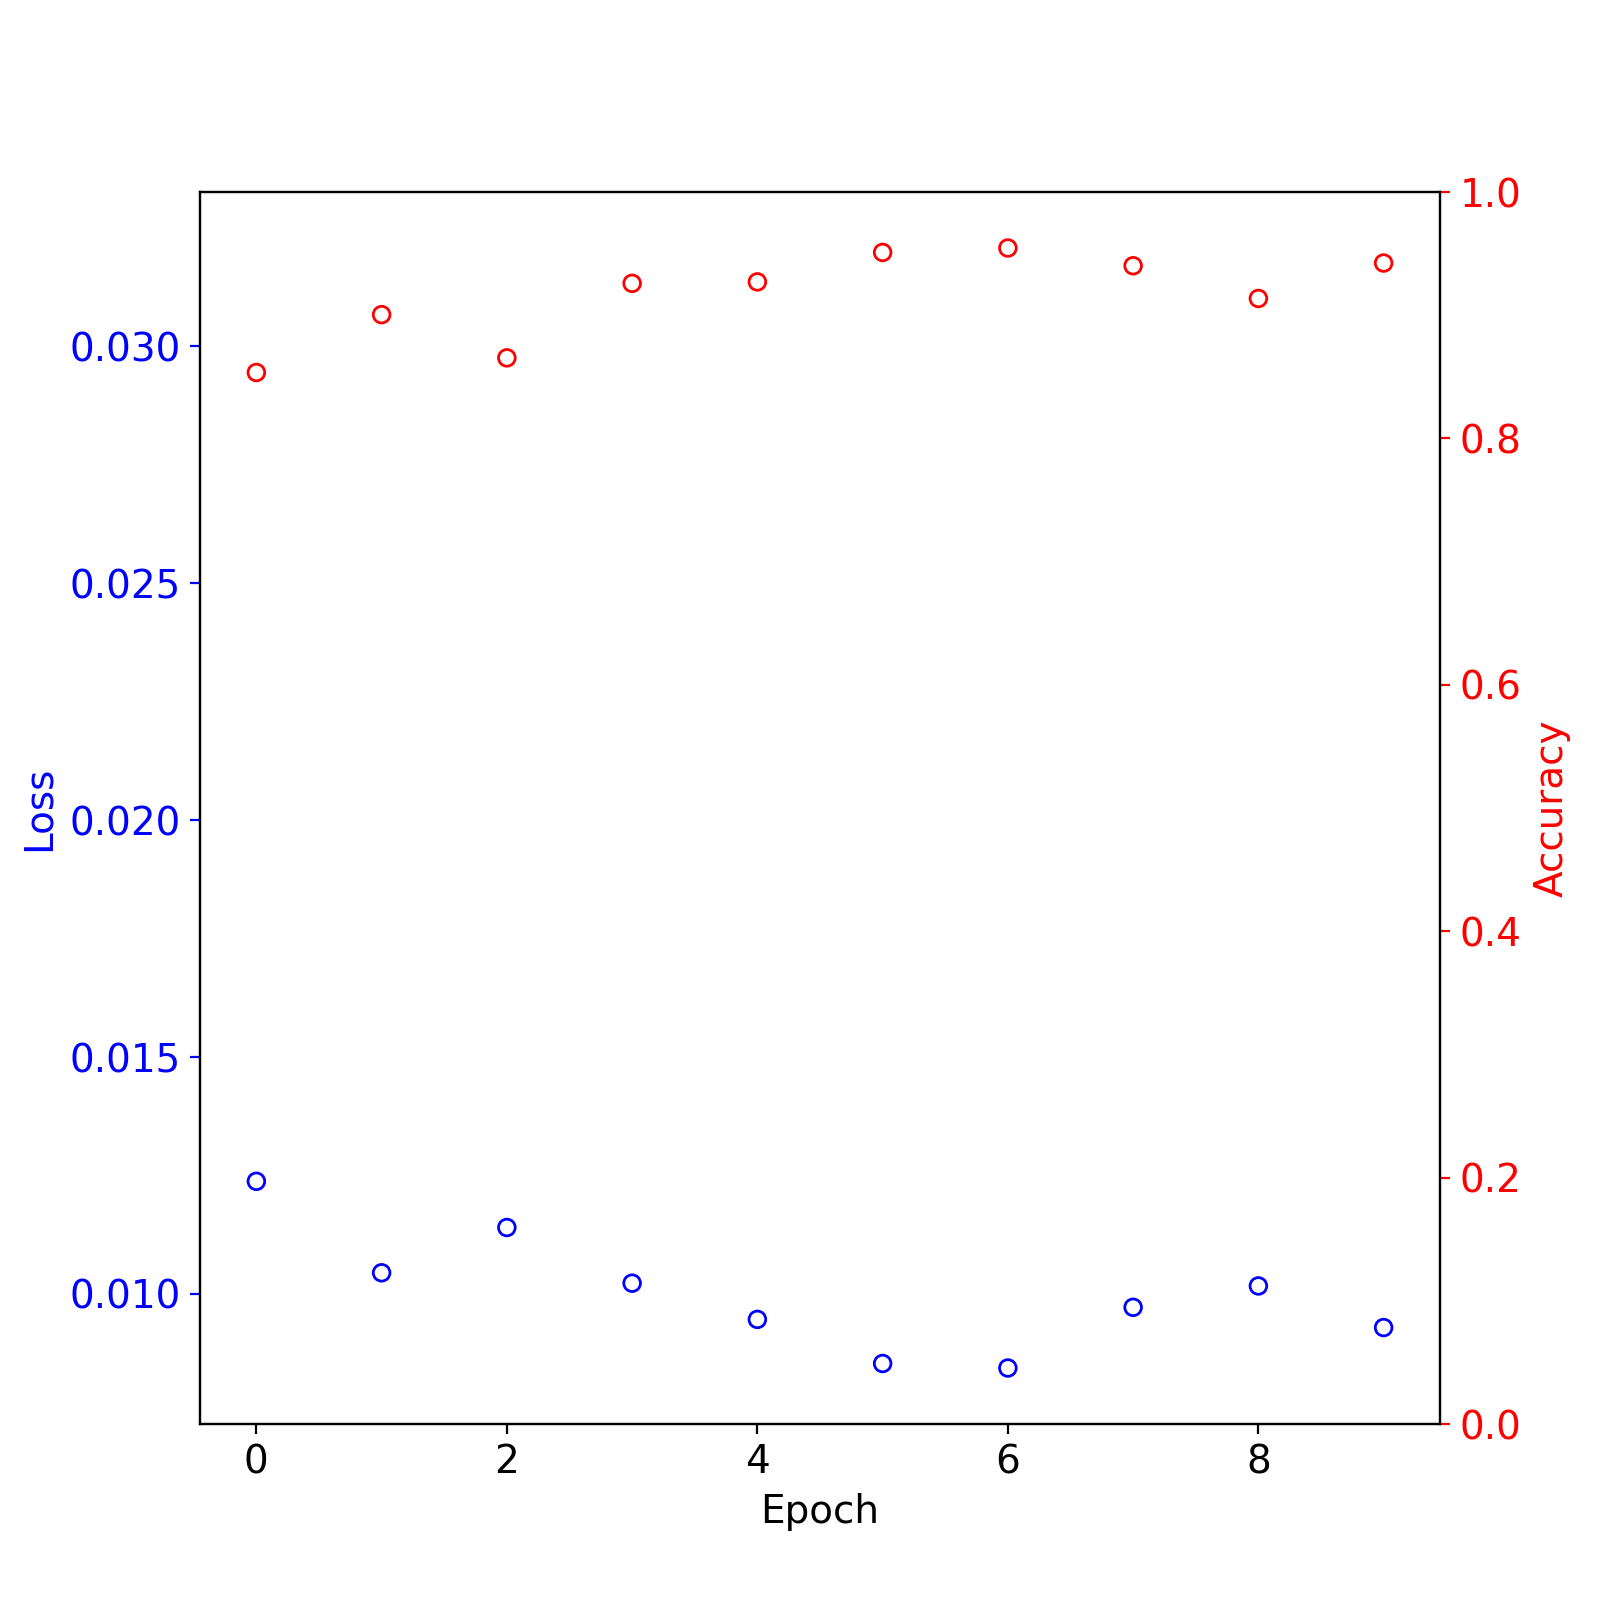

(0.0, 1.0)

In [20]:
%matplotlib notebook
fig, ax1 = plt.subplots(figsize=(8,8),facecolor='w')
line13 = ax1.scatter(np.arange(num_epochs), lossval, label='loss',
                     facecolors='none', edgecolors='blue',marker='o')

ax1.set_xlabel('Epoch',fontsize=14,color='black')
ax1.tick_params('x',colors='black',labelsize=14)
ax1.set_ylabel('Loss', fontsize=14,color='b')
ax1.tick_params('y',colors='b',labelsize=14)

ax2 = ax1.twinx()
line23 = ax1.scatter(np.arange(num_epochs), accuracy, label='accuracy',
                     facecolors='none', edgecolors='red',marker='o')


ax2.set_ylabel('Accuracy', fontsize=14,color='r')
ax2.tick_params('y',colors='r',labelsize=14)
ax2.set_ylim(0.,1.0)

### The ROC curve

In [21]:
# move the model to the CPU
model_cpu = copy.deepcopy(model)
model_cpu = model_cpu.cpu()
model_cpu.eval()

Sequential(
  (0): Linear(in_features=7, out_features=128, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): Tanh()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=32, out_features=1, bias=True)
  (10): Sigmoid()
)

In [22]:
torch.save(model_cpu, 'model.pt')
#model_cpu = torch.load('model.pt')

In [23]:
# calculate the fpr and tpr for all thresholds of the classification
x_test, y_test = test[['d_ppi','d_p_pvtx','d_pi_pvtx','pva','d_svtx_pvtx', 'alpha','q_t']].to_numpy(), test[['typ']]
scale = np.array([100., 100., 100., 1., 100., 1., 1.])
x_test = x_test/scale
# now scale your data using the StandardScaler
#scaler = StandardScaler()
#X_test = scaler.fit_transform(x_test)
y_test = y_test.to_numpy()

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

probs = model_cpu.forward(x_test)
probs = probs.detach().numpy()

In [24]:
accuracy_val = 0
kcut = 0.5
for i, j in zip(y_test, probs):
    j = 1 if j > kcut else 0
    if i==j: accuracy_val +=1
        
print (accuracy_val/y_test.shape[0])

0.8774108802325506


<IPython.core.display.Javascript object>


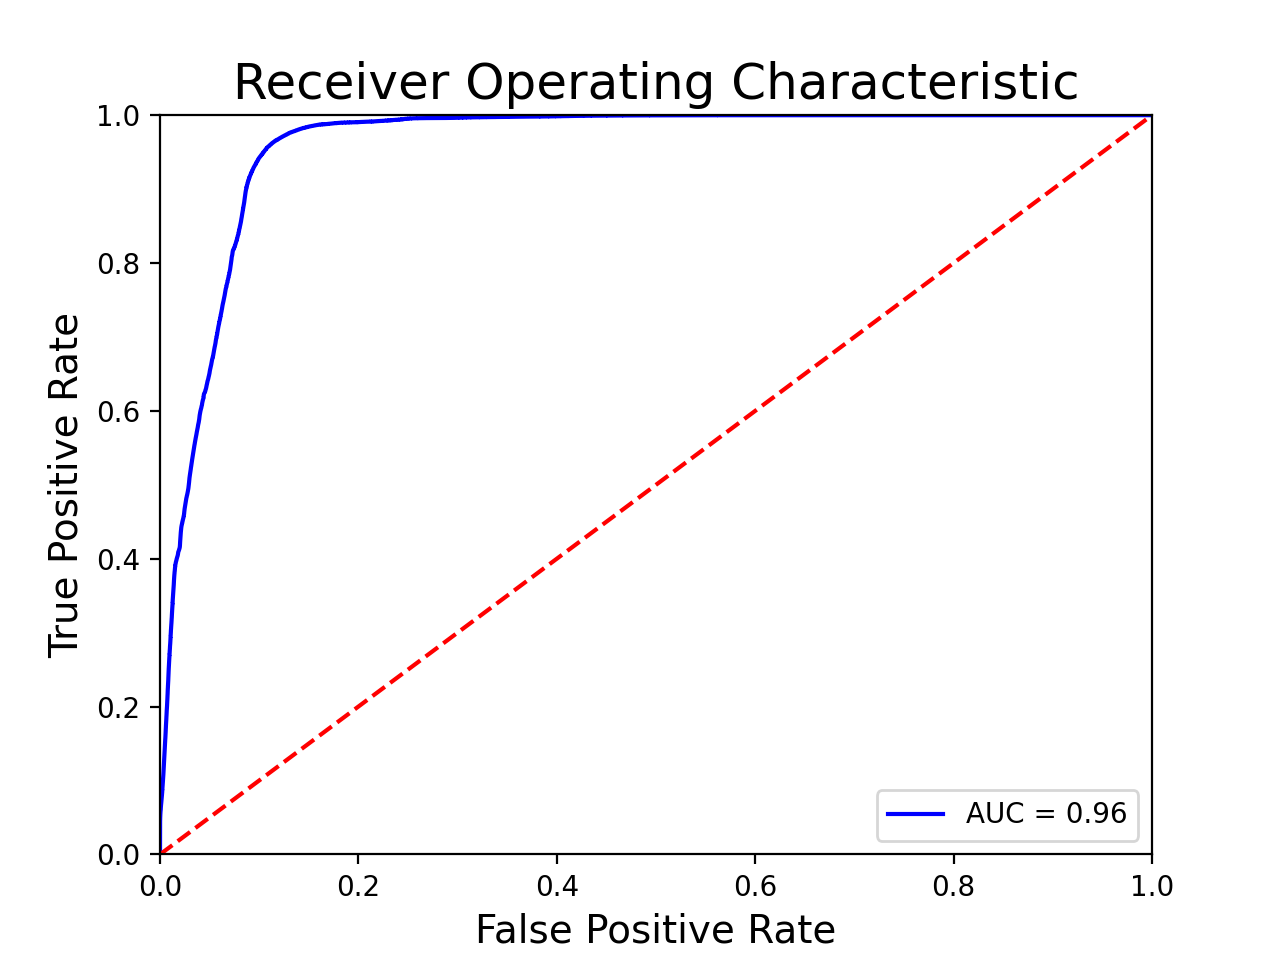

Text(0.5, 0, 'False Positive Rate')

In [29]:
%matplotlib notebook
y_hat = probs[:]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_hat)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic', fontsize=18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)

### The Confusion matrix
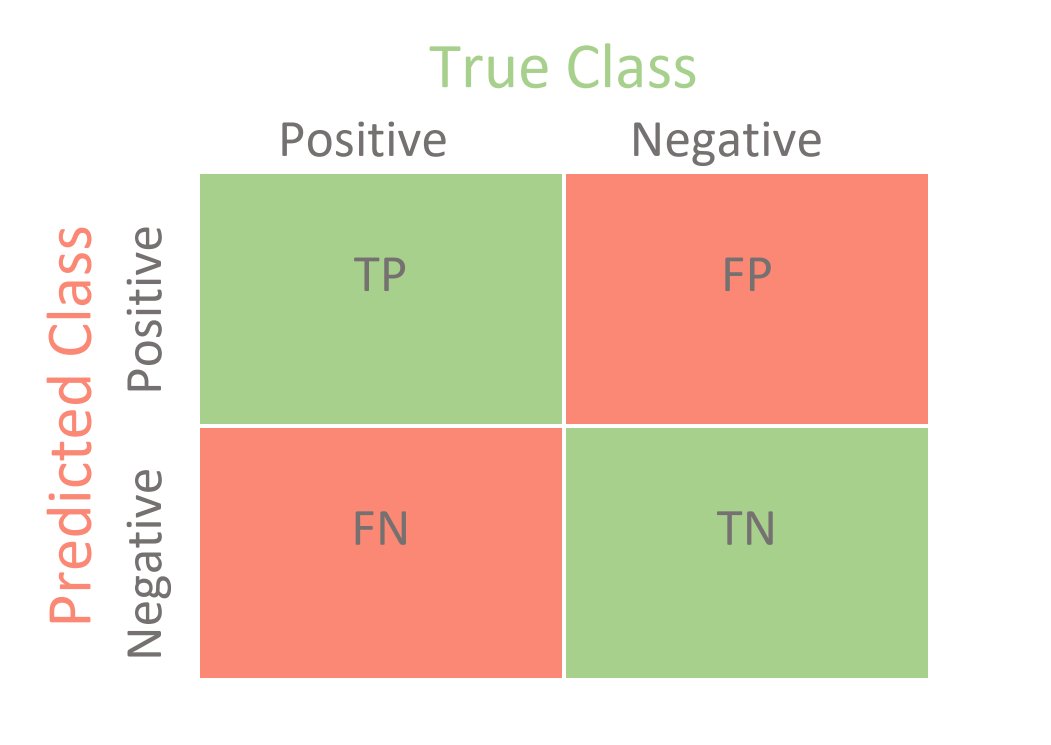

<IPython.core.display.Javascript object>


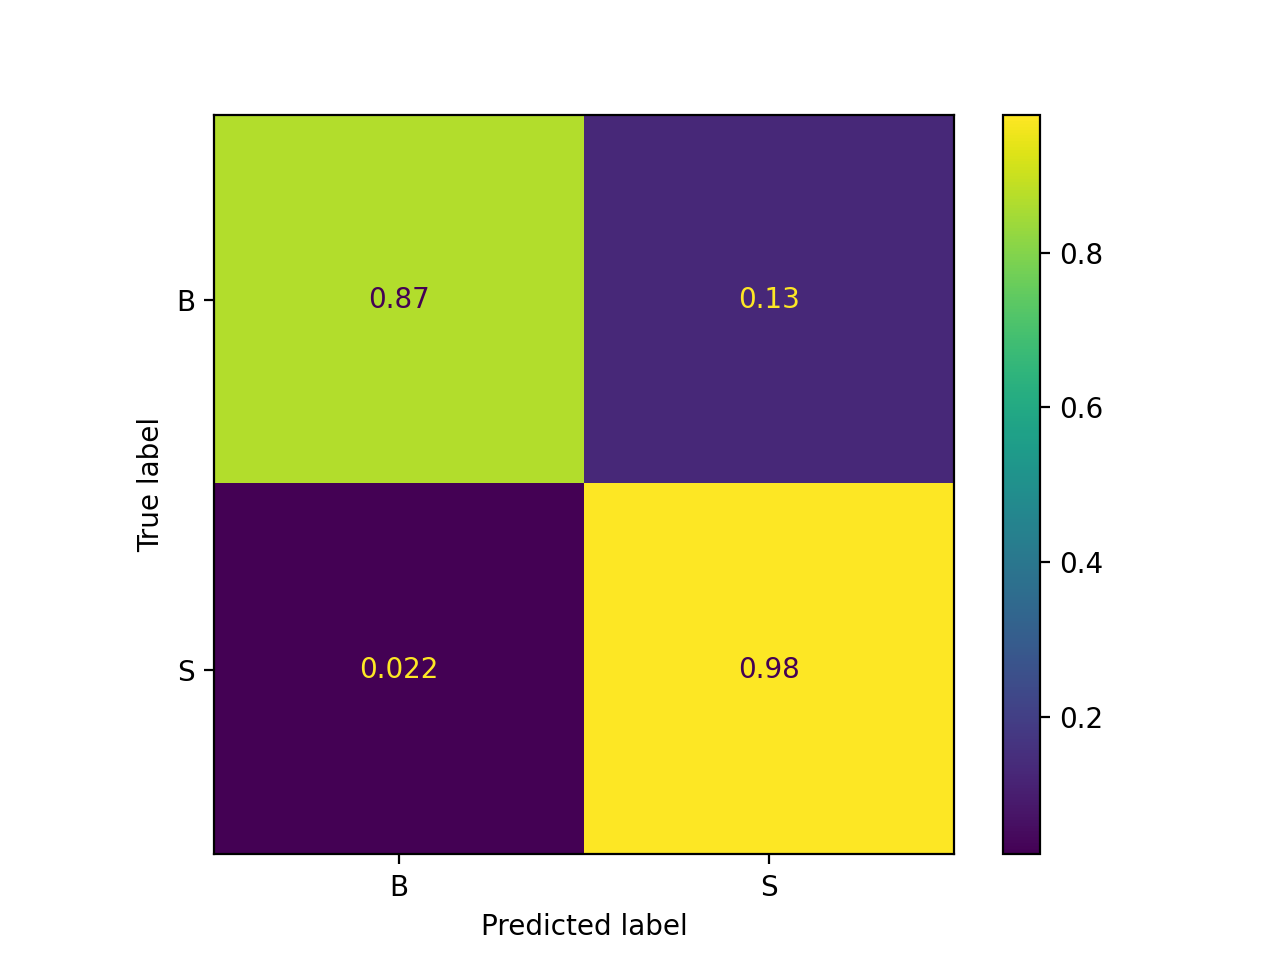

In [30]:
predictions = np.round(model_cpu.forward(x_test).detach().numpy())
cm = confusion_matrix(y_test.detach().numpy().flatten(), predictions.flatten())
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cmn,display_labels=['B','S'])
disp.plot()

### Plot the $p\pi^{-}$ invariant mass for selection of cuts

In [31]:
%%time
x_test, y_test = test[['d_ppi','d_p_pvtx','d_pi_pvtx','pva','d_svtx_pvtx', 'alpha','q_t']].to_numpy(), test[['typ']]
scale = np.array([100., 100., 100., 1., 100., 1., 1.])
x_test = x_test/scale
y_test = y_test.to_numpy()

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

probs = model_cpu.forward(x_test)
probs = probs.detach().numpy()

test['pred'] = probs

CPU times: user 1.31 s, sys: 308 ms, total: 1.62 s
Wall time: 424 ms


In [32]:
signal, bkg = test.loc[test.typ==1].to_numpy(), test.loc[test.typ==0].to_numpy()

In [33]:
kcuts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

<IPython.core.display.Javascript object>


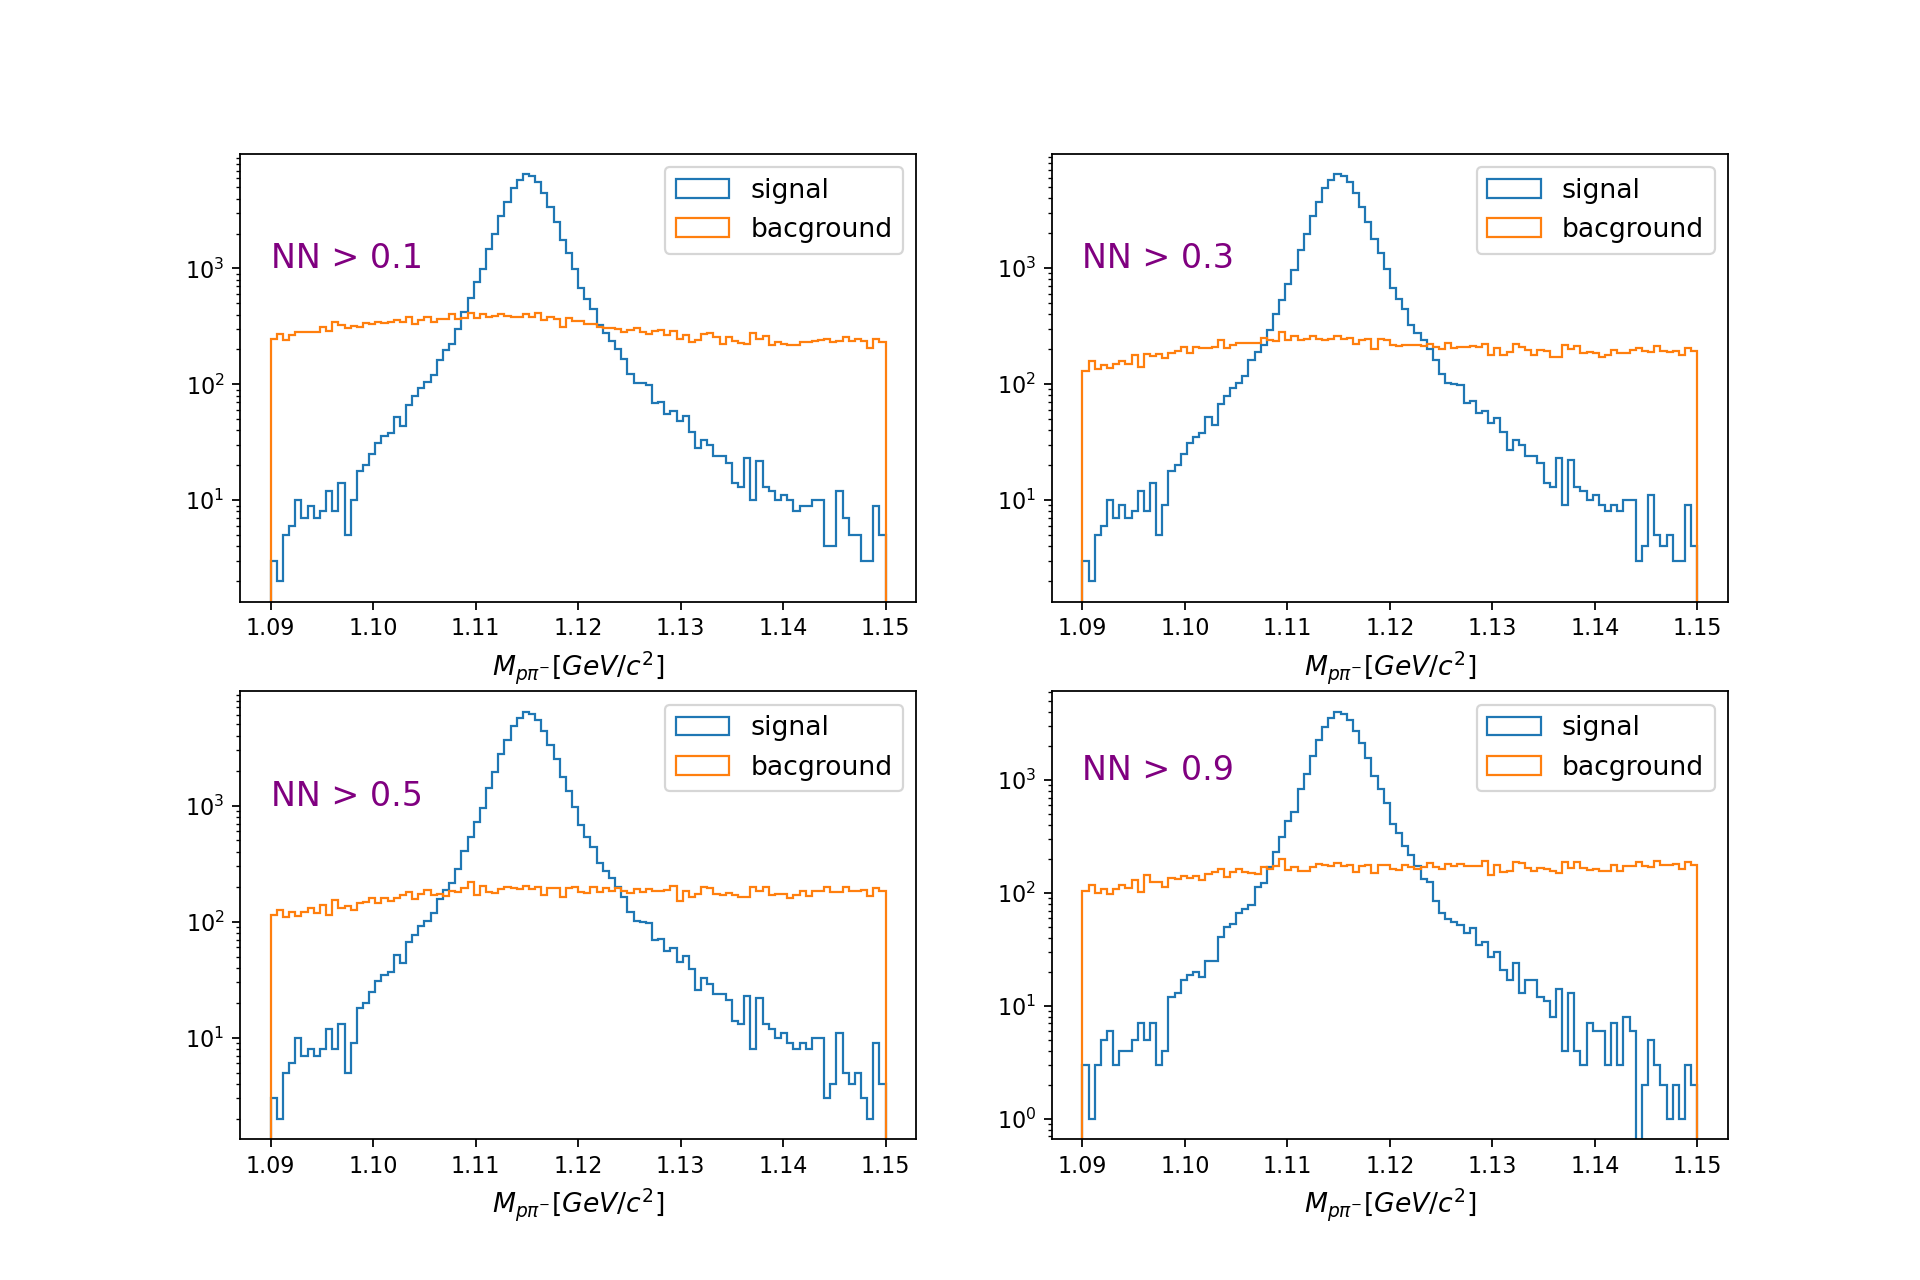

In [37]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 8), dpi=80)

df = train

plt.subplot(2, 2, 1)
plt.hist(signal[np.where(signal[:,-1]>kcuts[0])[0],-3], histtype='step', bins=100, label='signal', range=(1.090, 1.15), density=False)
plt.hist(bkg[np.where(bkg[:,-1]>kcuts[0])[0],-3], histtype='step', bins=100, label='bacground', range=(1.090, 1.15), density=False)
plt.xlabel(r'$M_{p\pi^{-}} [GeV/c^{2}]$', fontsize=12)
plt.semilogy()
plt.text(1.09, 1000, 'NN > 0.1', size=15, color='purple')
plt.legend(fontsize=12)


plt.subplot(2, 2, 2)
plt.hist(signal[np.where(signal[:,-1]>kcuts[2])[0],-3], histtype='step', bins=100, label='signal', range=(1.090, 1.15), density=False)
plt.hist(bkg[np.where(bkg[:,-1]>kcuts[2])[0],-3], histtype='step', bins=100, label='bacground', range=(1.090, 1.15), density=False)
plt.xlabel(r'$M_{p\pi^{-}} [GeV/c^{2}]$', fontsize=12)
plt.semilogy()
plt.text(1.09, 1000, 'NN > 0.3', size=15, color='purple')
plt.legend(fontsize=12)


plt.subplot(2, 2, 3)
plt.hist(signal[np.where(signal[:,-1]>kcuts[4])[0],-3], histtype='step', bins=100, label='signal', range=(1.090, 1.15), density=False)
plt.hist(bkg[np.where(bkg[:,-1]>kcuts[4])[0],-3], histtype='step', bins=100, label='bacground', range=(1.090, 1.15), density=False)
plt.xlabel(r'$M_{p\pi^{-}} [GeV/c^{2}]$', fontsize=12)
plt.semilogy()
plt.text(1.09, 1000, 'NN > 0.5', size=15, color='purple')
plt.legend(fontsize=12)


plt.subplot(2, 2, 4)
plt.hist(signal[np.where(signal[:,-1]>kcuts[-1])[0],-3], histtype='step', bins=100, label='signal', range=(1.090, 1.15), density=False)
plt.hist(bkg[np.where(bkg[:,-1]>kcuts[6])[-1],-3], histtype='step', bins=100, label='bacground', range=(1.090, 1.15), density=False)
plt.xlabel(r'$M_{p\pi^{-}} [GeV/c^{2}]$', fontsize=12)
plt.semilogy()
plt.text(1.09, 1000, 'NN > 0.9', size=15, color='purple')
plt.legend(fontsize=12)

In [50]:
%%time
ss = []
for cut in kcuts:
    S = signal[np.where(signal[:,-1]>cut)[0],-3]
    B = bkg[np.where(bkg[:,-1]>cut)[0],-3]
    S = (np.where((S>1.108) & (S<1.122))[0]).shape[0]
    B = (np.where((B>1.108) & (B<1.122))[0]).shape[0]
    
    ss.append(S/np.sqrt(S+B))

CPU times: user 28.4 ms, sys: 9 µs, total: 28.5 ms
Wall time: 26.4 ms


<IPython.core.display.Javascript object>


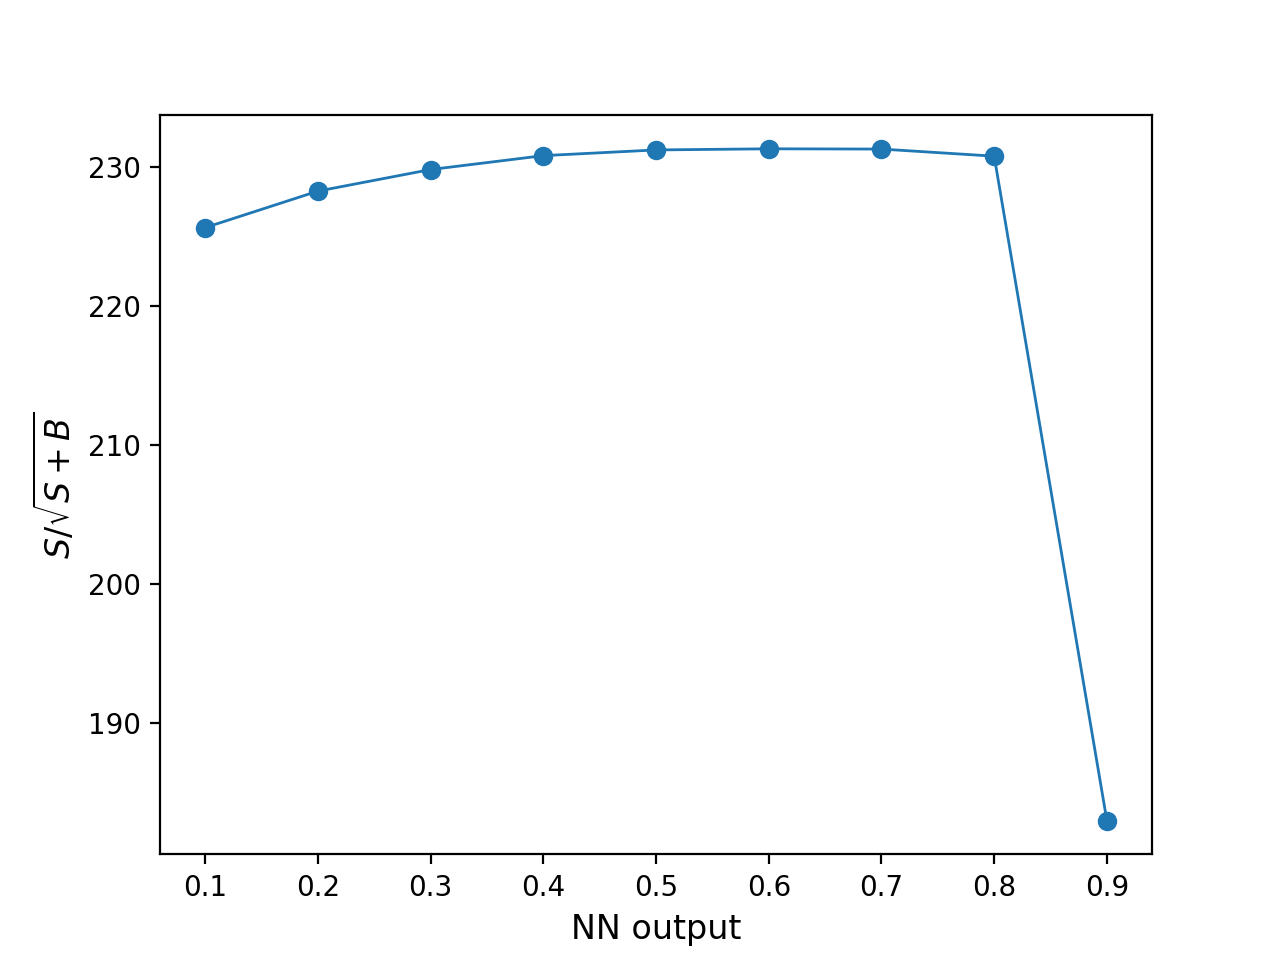

Text(0.5, 0, 'NN output')

In [54]:
%matplotlib notebook
plt.plot(kcuts, ss, linewidth=1)
plt.scatter(kcuts, ss)
plt.ylabel(r'$S/\sqrt{S+B}$', fontsize=12)
plt.xlabel(r'NN output', fontsize=12)